<a href="https://colab.research.google.com/github/dbtronics/COMP551-Miniproject-1/blob/db-local-branch/miniproject1_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cProfile import label
from IPython.core.debugger import set_trace         #for debugging 

In [2]:
def task1():
    data = arff.loadarff('messidor_features.arff')
    df = pd.DataFrame(data[0])
    df = df.replace({'?' : np.nan}).dropna()
    # print(df)
    # basic statistics df
    # print(df.describe(include='all'))
    # Document messidor features.arff above
    # Document hepatitis below
    df2 = pd.read_csv('hepatitis1.csv', 
    names=["class", "age", "sex", "steroid", "antivirals", 
    "fatigue", "malaise", "anorexia", "liver_big", "liver_firm", 
    "spleen_palpable", "spiders", "ascites", "varices", "bilirubin", 
    "alk_phosphate", "sgot", "albumin", "protime", "histology"])
    df2 = df2.replace({'?': np.nan}).dropna()
    # print(df2)
    # basic statistics df2
    # print(df2.describe(include='all'))
    df = df.to_numpy()
    df2 = df2.to_numpy()
    return df, df2 # messidor and hep data respectively


In [3]:
#it is important to set the seed for reproducibility as it initializes the random number generator
np.random.seed(1234)

#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html   
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

    def evaluate_acc(self, y_test, y_pred):
        # correct_pred = y_test == y_pred # gets all the index of correct prediction
        # accuracy = np.sum(y_test == y_pred) # in percentage
        # accuracy /= y_test.shape[0] * 100
        correct_pred, accuracy = 0, 0
        for i in range(y_pred.shape[0]): correct_pred += y_test[i] == y_pred[i]
        accuracy = correct_pred/(y_pred.shape[0]) * 100
        return accuracy


In [4]:
def task2(k, depth, x_train, y_train, x_test):
    # import KNN as kmodel
    model_knn = KNN(k)
    y_prob_knn, knn = model_knn.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(y_prob_knn, axis = -1)
    accuracy_knn = model_knn.evaluate_acc(y_train, y_pred)
    return accuracy_knn


In [10]:
def decision_boundary(x, x_train, y_train):
    #we can make the grid finer by increasing the number of samples from 200 to higher value
    x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
    x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

    #to features values as a mesh  
    x0, x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T

    for k in range(1,4):
        # import KNN as kmodel
        model = KNN(K=k)

        C = np.max(y_train) + 1
        y_train_prob = np.zeros((y_train.shape[0], C))
        y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

        #to get class probability of all the points in the 2D grid
        y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

        y_pred_all = np.zeros_like(y_prob_all)
        y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1
        print(x_train[:,0].shape)
        print(x_train[:,1].shape)
        print(y_train_prob.shape)
        plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
        plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
        plt.show()

K =  1
Messidore Accuracy:  44.58874458874459
Hepatitis Accuracy:  93.75


K =  2
Messidore Accuracy:  44.58874458874459
Hepatitis Accuracy:  75.0


K =  3
Messidore Accuracy:  44.58874458874459
Hepatitis Accuracy:  87.5


K =  4
Messidore Accuracy:  44.58874458874459
Hepatitis Accuracy:  87.5


K =  5
Messidore Accuracy:  44.58874458874459
Hepatitis Accuracy:  87.5


(64,)
(64,)
(64, 3)


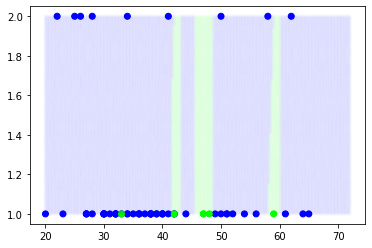

(64,)
(64,)
(64, 3)


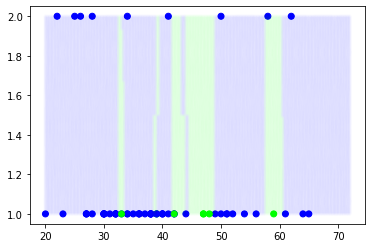

(64,)
(64,)
(64, 3)


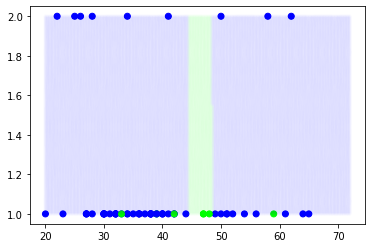

In [12]:
mess_data, hep_data = task1()
    
mess_data = mess_data.astype(np.float64)
hep_data = hep_data.astype(np.float64)

# parameter adjustments
k_range = 6
train_portion = 8/10 # meaning 1/3 will be test portion
num_features = 2
    
# 66% of train data and 33% of test data
n_mess_train, n_hep_train = int(mess_data.shape[0] * train_portion), int(hep_data.shape[0] * train_portion)
    
# train data set for messidore
mess_x_train = mess_data[:n_mess_train, :num_features] # All columns except last one
# mess_y_train = mess_data[:n_mess_train, -1].reshape(n_mess_train, 1) # only get last column i.e. class
mess_y_train = mess_data[:n_mess_train, -1]
mess_y_train = mess_y_train.astype(np.int32)
# test data set for messidore
mess_x_test = mess_data[n_mess_train:, :num_features]
# mess_y_test = mess_data[n_mess_train:, -1].reshape(mess_data.shape[0] - n_mess_train, 1)
mess_y_test = mess_data[n_mess_train:, -1]
mess_y_test = mess_y_test.astype(np.int32)

#train data set for hepatitis
hep_x_train = hep_data[:n_hep_train, 1:1+num_features]
# hep_y_train = hep_data[:n_hep_train, 0].reshape(n_hep_train, 1)
hep_y_train = hep_data[:n_hep_train, 0]
hep_y_train = hep_y_train.astype(np.int32)
#test data set for hepatitis
hep_x_test = hep_data[n_hep_train:, 1:1+num_features]
# hep_y_test = hep_data[n_hep_train:, 0].reshape(hep_data.shape[0] - n_hep_train, 1)
hep_y_test = hep_data[n_hep_train:, 0]
hep_y_test = hep_y_test.astype(np.int32)

## We have test and train for both
## Let's work from here
for i in range(1, k_range):
  print("K = ", i)
  print("Messidore Accuracy: ", task2(i, 9, mess_x_train, mess_y_train, mess_x_test))
  print("Hepatitis Accuracy: ", task2(i, 9, hep_x_train, hep_y_train, hep_x_test))
  print("\n")

decision_boundary(hep_data[:, 1:], hep_x_train, hep_y_train)